In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

2025-05-16 17:52:02.756424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747417922.971367      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747417923.036649      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [2]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]                
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,676 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease                        
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,726 kB]           
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease       
Get:11 h

In [3]:
#preparing data set

ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [4]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [5]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)

In [6]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-06-02-01-01-07.wav
03
/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav
5
03-01-05-02-01-02-07.wav


In [7]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

In [8]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())

Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


In [9]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [10]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())

Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


In [11]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [12]:
print(data_path.Emotions.value_counts())

Emotions
disgust     1923
sad         1923
fear        1923
happy       1923
angry       1923
neutral     1895
surprise     652
Name: count, dtype: int64


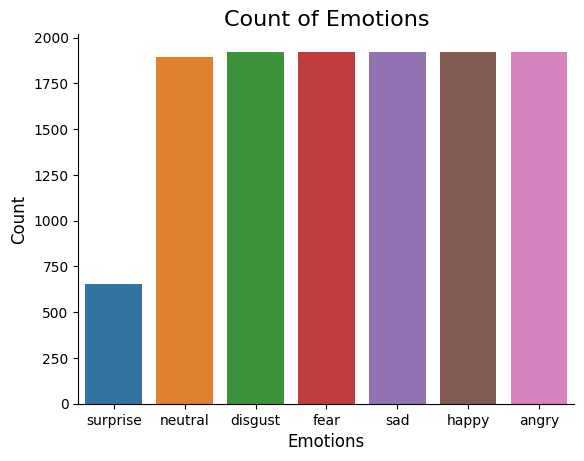

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [14]:
data,sr = librosa.load(file_path[0])
sr

22050

In [15]:
ipd.Audio(data,rate=sr)

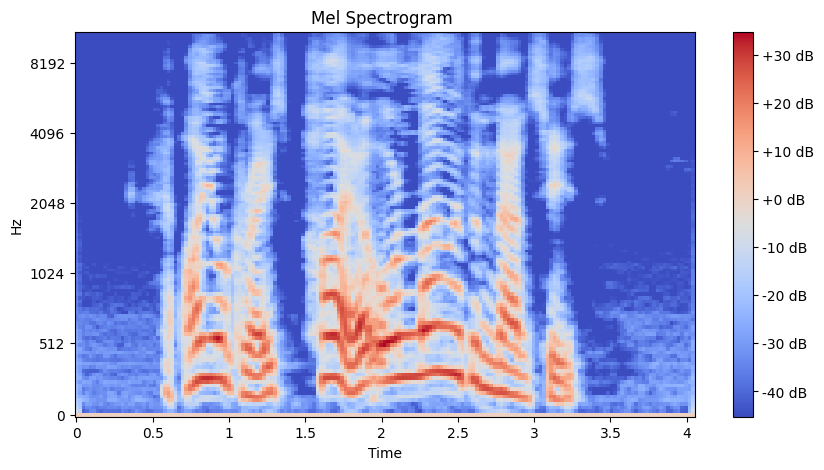

In [16]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

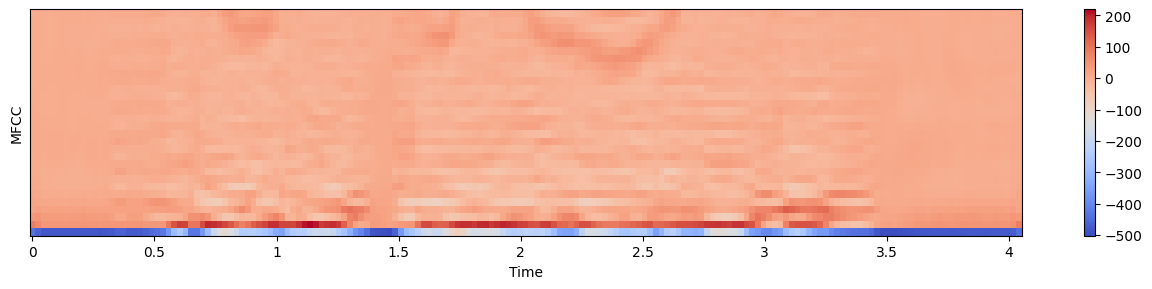

In [17]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

In [18]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

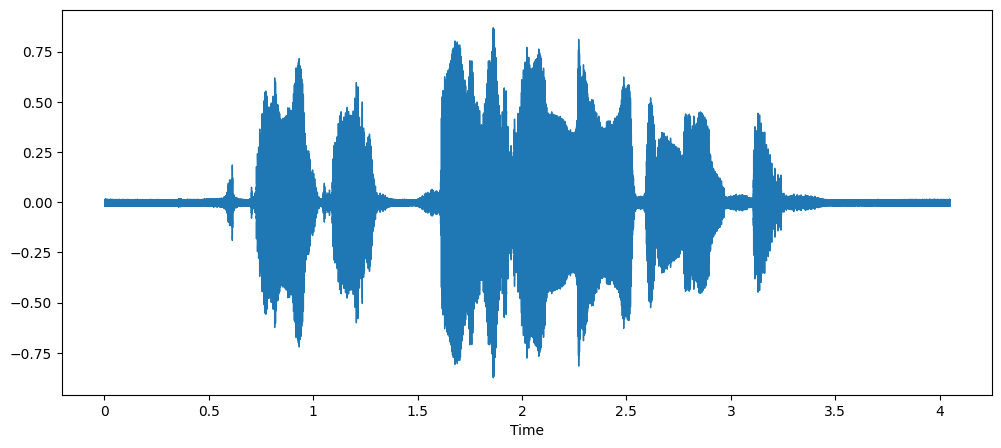

In [19]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

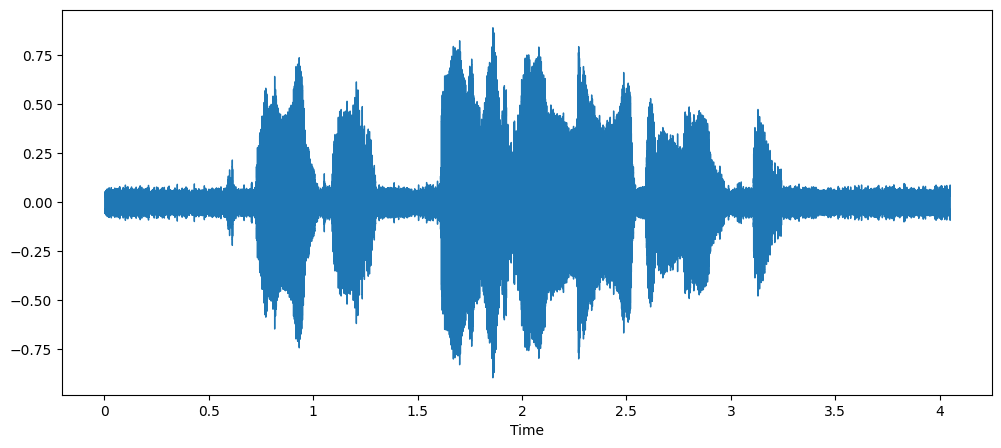

In [20]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [21]:
# STRETCHED AUDIO
def stretch(data, rate=0.8):
    stft = librosa.stft(data)
    stretched_stft = librosa.effects.time_stretch(stft, rate)
    return librosa.istft(stretched_stft)

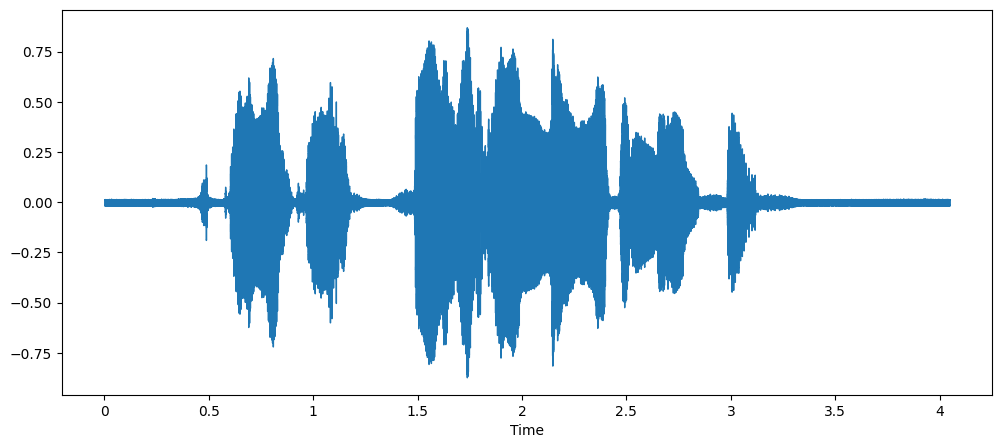

In [22]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

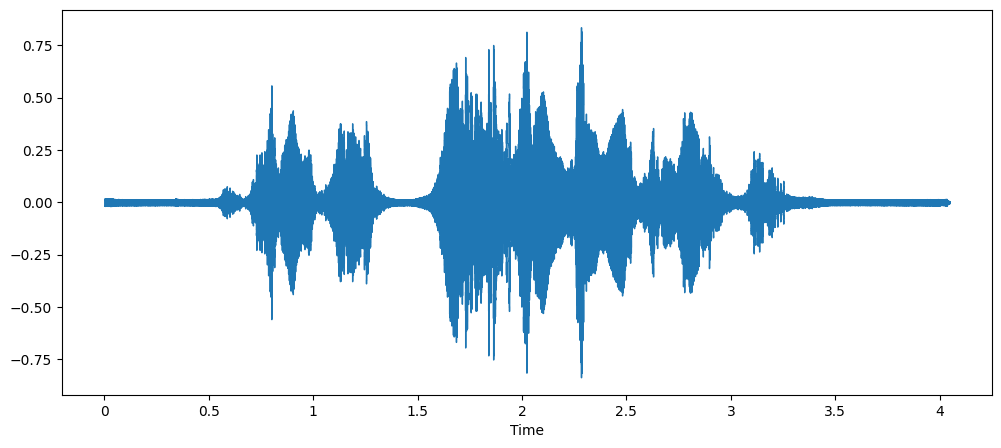

In [23]:
# AUDIO WITH PITCH
# Define pitch shift function
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Use it
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [24]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [25]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [26]:
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rms)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfccs.T) if not flatten else np.ravel(mfccs.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((
        result,
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        mfcc(data, sr, frame_length, hop_length)
    ))
    return result


In [27]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  8.99it/s]

0 audio has been processed


502it [00:50, 10.03it/s]

500 audio has been processed


1002it [01:40,  9.99it/s]

1000 audio has been processed


1502it [02:28, 12.85it/s]

1500 audio has been processed


2002it [03:07, 13.86it/s]

2000 audio has been processed


2502it [03:47, 11.98it/s]

2500 audio has been processed


3002it [04:27, 12.76it/s]

3000 audio has been processed


3502it [05:07, 12.85it/s]

3500 audio has been processed


4002it [05:48, 12.28it/s]

4000 audio has been processed


4502it [06:28, 12.45it/s]

4500 audio has been processed


5002it [07:08, 12.79it/s]

5000 audio has been processed


5502it [07:48, 13.03it/s]

5500 audio has been processed


6002it [08:29, 11.30it/s]

6000 audio has been processed


6502it [09:10, 11.22it/s]

6500 audio has been processed


7002it [09:52, 12.06it/s]

7000 audio has been processed


7502it [10:34, 12.57it/s]

7500 audio has been processed


8002it [11:16, 12.14it/s]

8000 audio has been processed


8502it [11:58, 11.05it/s]

8500 audio has been processed


9002it [12:38, 14.59it/s]

9000 audio has been processed


9502it [13:11, 12.03it/s]

9500 audio has been processed


10002it [13:50, 13.24it/s]

10000 audio has been processed


10502it [14:33, 13.09it/s]

10500 audio has been processed


11002it [15:11, 13.49it/s]

11000 audio has been processed


11502it [15:49, 13.72it/s]

11500 audio has been processed


12002it [16:35,  9.72it/s]

12000 audio has been processed


12162it [16:51, 12.02it/s]

Done
Time:  1011.7804719799999


In [28]:
len(X), len(Y), data_path.Path.shape

(48648, 48648, (12162,))

In [29]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.259277,0.390625,0.515137,0.509766,0.494141,0.489746,0.476074,0.475098,0.479004,0.479492,...,8.577179,8.118570,2.381668,-4.361311,-0.188619,-1.298001,-0.796360,0.925215,0.819587,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838667,1.308736,1.855117,2.405196,2.896454,3.283496,3.541684,3.667480,surprise
3,0.246582,0.372559,0.503906,0.509766,0.503906,0.501953,0.487305,0.475098,0.490234,0.486328,...,-9.623101,-0.161685,1.551252,-2.066428,-2.440693,-1.779872,-5.017792,-2.118963,-2.297755,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [30]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517691,-1.716481,-1.599312,-1.234615,-0.693200,-0.038981,0.675205,1.405603,2.112302,surprise
1,0.259277,0.390625,0.515137,0.509766,0.494141,0.489746,0.476074,0.475098,0.479004,0.479492,...,8.577179,8.118570,2.381668,-4.361311,-0.188619,-1.298001,-0.796360,0.925215,0.819587,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838667,1.308736,1.855117,2.405196,2.896454,3.283496,3.541684,3.667480,surprise
3,0.246582,0.372559,0.503906,0.509766,0.503906,0.501953,0.487305,0.475098,0.490234,0.486328,...,-9.623101,-0.161685,1.551252,-2.066428,-2.440693,-1.779872,-5.017792,-2.118963,-2.297755,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586420,2.746858,2.223281,0.986924,-0.730691,-2.530884,-4.002835,-4.849377,-4.929749,neutral


In [31]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [32]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [33]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [34]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [35]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [36]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [38]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [39]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [40]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [41]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [42]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [43]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [44]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    
    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),  # Fixed
    
    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    
    L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding='same'),
    L.Dropout(0.2),  # Fixed
    
    L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding='same'),
    L.Dropout(0.2),  # Fixed
    
    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.BatchNormalization(),
    L.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1747419173.981637      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747419173.982334      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9600)                │              

 Total params: 7,193,223 (27.44 MB)

 Trainable params: 7,188,871 (27.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [45]:
history=model.fit(x_traincnn, y_train, epochs=20, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/20


I0000 00:00:1747419182.961796     815 service.cc:148] XLA service 0x7d004802c270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747419182.962568     815 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747419182.962586     815 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747419183.676800     815 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747419194.171302     815 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


609/609 ━━━━━━━━━━━━━━━━━━━━ 161s 235ms/step - accuracy: 0.4034 - loss: 1.6605 - val_accuracy: 0.4168 - val_loss: 1.5534 - learning_rate: 0.0010
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.5541 - loss: 1.1482 - val_accuracy: 0.5821 - val_loss: 1.0917 - learning_rate: 0.0010
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 143s 236ms/step - accuracy: 0.6122 - loss: 1.0001 - val_accuracy: 0.5825 - val_loss: 1.1481 - learning_rate: 0.0010
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.6596 - loss: 0.8873 - val_accuracy: 0.6420 - val_loss: 0.9741 - learning_rate: 0.0010
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.7142 - loss: 0.7524 - val_accuracy: 0.6583 - val_loss: 0.9250 - learning_rate: 0.0010
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.7559 - loss: 0.6531 - val_accuracy: 0.6884 - val_loss: 0.8108 - learning_rate: 0.0010
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.7938 

305/305 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9587 - loss: 0.1415
Accuracy of our model on test data :  95.65262198448181 %


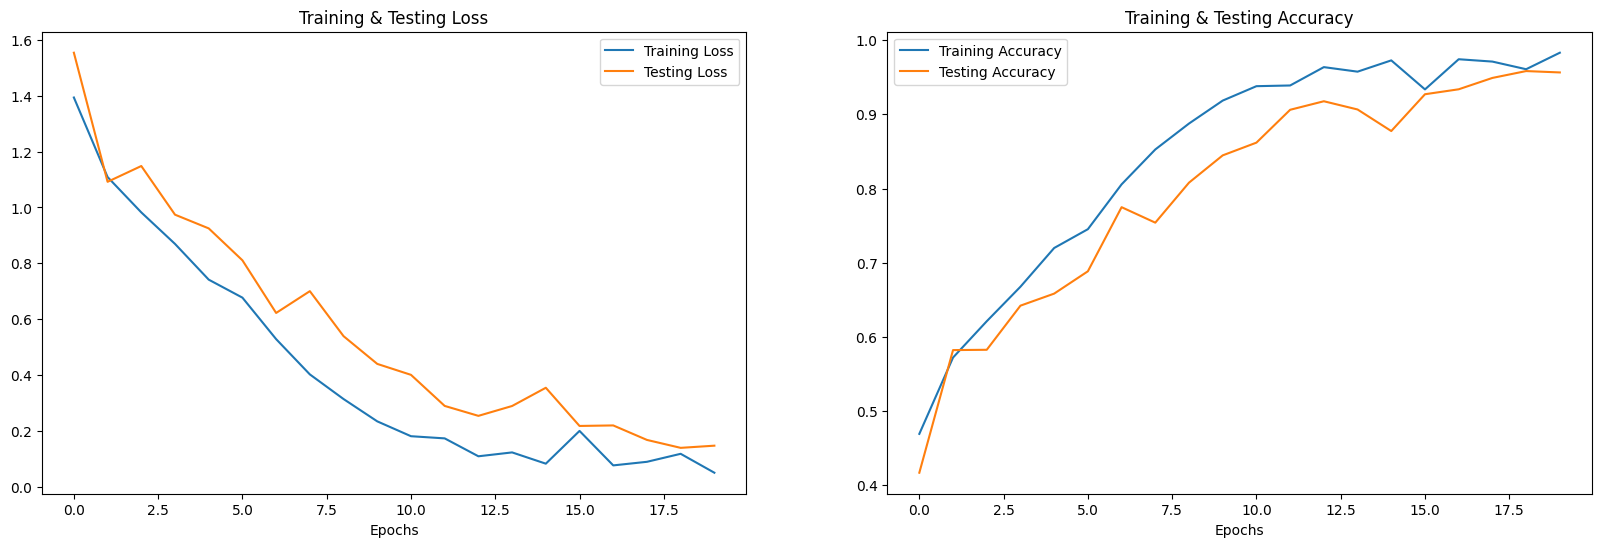

In [46]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = range(len(history.history['loss']))  # <- Fix here
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [47]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [48]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


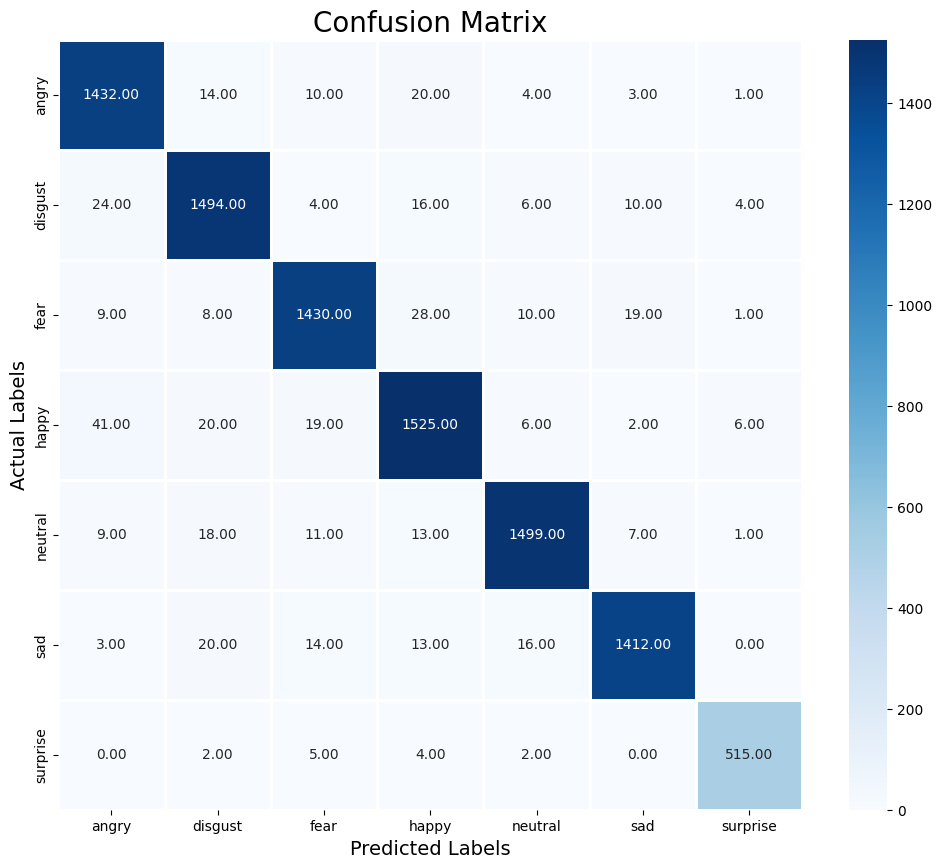

              precision    recall  f1-score   support

       angry       0.94      0.96      0.95      1484
     disgust       0.95      0.96      0.95      1558
        fear       0.96      0.95      0.95      1505
       happy       0.94      0.94      0.94      1619
     neutral       0.97      0.96      0.97      1558
         sad       0.97      0.96      0.96      1478
    surprise       0.98      0.98      0.98       528

    accuracy                           0.96      9730
   macro avg       0.96      0.96      0.96      9730
weighted avg       0.96      0.96      0.96      9730



In [49]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [50]:
# Save model architecture to JSON
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights with correct filename extension
model.save_weights("CNN_model.weights.h5")

print("Saved model to disk")

Saved model to disk


In [51]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [52]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9605 - loss: 0.1374
compile_metrics: 95.84%


In [53]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [54]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [55]:
import pickle

with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [56]:
import librosa

In [57]:
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40, 
                                n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [58]:
def get_predict_feat(path):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d, s_rate)  # Pass s_rate!
    result = np.array(res)
    
    # Reshape dynamically or pad to 2376
    if result.shape[0] > 2376:
        result = result[:2376]
    else:
        result = np.pad(result, (0, 2376 - result.shape[0]))
        
    result = result.reshape(1, 2376)
    i_result = scaler2.transform(result)
    final_result = np.expand_dims(i_result, axis=2)
    return final_result

In [59]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [60]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [61]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
sad


In [62]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
happy


In [63]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
fear


In [64]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
angry


In [65]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
fear


In [66]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
fear


In [67]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
fear


In [68]:
# Save the full model
model.save('/kaggle/working/CNN_full_model.h5')
print("✅ Full model saved as CNN_full_model.h5")

# Save the scaler
import pickle
with open('/kaggle/working/scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Save the encoder
with open('/kaggle/working/encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

print("✅ Scaler and Encoder pickled")

✅ Full model saved as CNN_full_model.h5
✅ Scaler and Encoder pickled


In [78]:
# ✅ Install required libraries
!pip install --quiet google-api-python-client google-auth-httplib2 google-auth-oauthlib

from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# ✅ Path to your uploaded .json key from your Kaggle dataset
SERVICE_ACCOUNT_FILE = '/kaggle/input/our-velocity-460004-b1-5b54e5408593/our-velocity-460004-b1-5b54e5408593.json'

# ✅ Your Google Drive folder ID from the shared folder
FOLDER_ID = '15FewlzY5VoUe_WjWWPH3An_rxPOjoybY'  # <-- updated folder ID

# ✅ Authenticate
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE,
    scopes=['https://www.googleapis.com/auth/drive']
)
service = build('drive', 'v3', credentials=credentials)

# ✅ Files to upload
files_to_upload = [
    ('/kaggle/working/CNN_full_model.h5', 'CNN_full_model.h5'),
    ('/kaggle/working/scaler2.pickle', 'scaler2.pickle'),
    ('/kaggle/working/encoder2.pickle', 'encoder2.pickle')
]

# ✅ Upload loop
for local_path, drive_filename in files_to_upload:
    file_metadata = {
        'name': drive_filename,
        'parents': [FOLDER_ID]
    }
    media = MediaFileUpload(local_path, resumable=True)
    uploaded_file = service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id'
    ).execute()
    print(f"✅ Uploaded {drive_filename} to Google Drive (File ID: {uploaded_file.get('id')})")

✅ Uploaded CNN_full_model.h5 to Google Drive (File ID: 1rNjobTEVv7iylFSPinYdohpZS-rs5YRJ)
✅ Uploaded scaler2.pickle to Google Drive (File ID: 1aEN09Avk2G9_Oso7Nl3kLit4cCFphtMo)
✅ Uploaded encoder2.pickle to Google Drive (File ID: 1INMy6xujSKvW__RAeVUEJRjTqvPdzeQ8)
